# Identificación de carros con redes neuronales convolucionales

Se utilizará un set de imágenes para detectar carros en una carretera.

Dirección del set de datos: https://www.kaggle.com/datasets/sshikamaru/car-object-detection<br/>
Cantidad de imágenes: 1178

El objetivo de aprender redes neuronales convolucionales para determinar si en una imagen hay un carro, a continuación se utilizará el modelo yolo para identificar la ubicación de cada carro.

# Librerías a utilizar en el proyecto

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, Rescaling
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import Recall, BinaryAccuracy, Precision, MeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf
from sklearn.metrics import classification_report, mean_squared_error

Evita imprimir varios logs al momento de entrenar el modelo con Keras

In [2]:
from tqdm.keras import TqdmCallback

Redimensionamiento de imagenes para analisis:

In [3]:
aspect_ratio = 0.4

# Carga de datos

El siguiente listado contiene que imagenes tienen un carro y las coordenadas en pixeles de donde se encuentra el carro.

In [4]:
y_carros = pd.read_csv('data2/data/train_solution_bounding_boxes (1).csv') 
print("Registros:", len(y_carros))
y_carros.head()

Registros: 559


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


Tamaño de las imagenes

In [5]:
image_width = 676
image_height = 380

Normalizando pixeles

In [6]:
y_carros.xmin = y_carros.xmin/image_width
y_carros.ymin = y_carros.ymin/image_height
y_carros.xmax = y_carros.xmax/image_width
y_carros.ymax = y_carros.ymax/image_height

Carga de imagenes para entrenamiento

In [7]:
x_carros = pd.DataFrame({'image': os.listdir('data2/data/training_images/images/')})
print("Registros:", len(x_carros))
x_carros.head()

Registros: 1001


,image
0,vid_4_1000.jpg
1,vid_4_10000.jpg
2,vid_4_10020.jpg
3,vid_4_10040.jpg
4,vid_4_10060.jpg


Uniendo ambos set de datos.

In [8]:
carros = x_carros.merge(y_carros, how = 'left', on = ['image'])
print("Registros:", len(carros))
carros.head()

Registros: 1205


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,0.416064,0.492198,0.484805,0.587436
1,vid_4_10000.jpg,0.022431,0.492198,0.178003,0.622185
2,vid_4_10020.jpg,0.734443,0.453588,0.931983,0.609315
3,vid_4_10040.jpg,0.353835,0.465171,0.535456,0.622185
4,vid_4_10060.jpg,0.024602,0.490911,0.196093,0.627333


Identificando por que el set de datos resultantes es mayor a las imagenes de entrenamiento:

In [9]:
carros_duplicados = carros["image"]
carros_duplicados = carros_duplicados[carros["image"].duplicated()].reset_index(drop=True)
carros_duplicados[0:5]

0    vid_4_12140.jpg
1    vid_4_12160.jpg
2    vid_4_12160.jpg
3    vid_4_12180.jpg
4    vid_4_12180.jpg
Name: image, dtype: object

Una imagen puede tener más de un carro, a continuación un ejemplo:

In [10]:
ejemplo_duplicado = carros[carros["image"] == carros_duplicados[0]]
ejemplo_duplicado

,image,xmin,ymin,xmax,ymax
101,vid_4_12140.jpg,0.309696,0.485763,0.469609,0.592584
102,vid_4_12140.jpg,0.876266,0.445866,0.949349,0.553974


Función para graficar recuadros:

In [11]:
def graficar_cuadros(ruta, coordenadas):
    im = Image.open(ruta)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)
    
    for row in coordenadas:
        # Create a Rectangle patch
        xmin = float(row[0])*image_width
        ymin = float(row[1])*image_height
        xmax = float(row[2])*image_width
        ymax = float(row[3])*image_height
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Add the patch to the Axes
    plt.show()

Graficando los carros en la imagen:

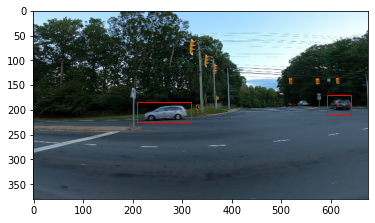

In [12]:
ruta = 'data2/data/training_images/images/'+ejemplo_duplicado.iloc[0,0]
coordenadas = ejemplo_duplicado.iloc[:,1:5]
graficar_cuadros(ruta, np.array(coordenadas))

Para evitar duplicar registros para cada carro, se agregarán más columnas para registrar hasta 7 carros. El siguiente código agrega un registro de imagen una sola vez:

In [13]:
carros_duplicados = y_carros[y_carros["image"].duplicated()]
carros_sin_duplicar = y_carros[y_carros["image"].duplicated()==False]

carros = x_carros.merge(carros_sin_duplicar, how = 'left', on = ['image'])
carros.insert(1, 'carros', 1)

sin_carros = carros["xmin"].isnull()
carros.loc[sin_carros, ["carros", "xmin", "ymin", "xmax", "ymax"]] = 0
print("Registros:", len(carros))
carros.head()

Registros: 1001


,image,carros,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,1,0.416064,0.492198,0.484805,0.587436
1,vid_4_10000.jpg,1,0.022431,0.492198,0.178003,0.622185
2,vid_4_10020.jpg,1,0.734443,0.453588,0.931983,0.609315
3,vid_4_10040.jpg,1,0.353835,0.465171,0.535456,0.622185
4,vid_4_10060.jpg,1,0.024602,0.490911,0.196093,0.627333


A conginuación se agregarán la cantidad necesarias de columnas para registrar las coordenadas de la maxima cantidad de carros en una imagen.

In [14]:
maxima_repitencia = max(carros_duplicados.groupby('image').size()) + 1
print("Maxima repitencia:", maxima_repitencia)
for i in range(2, maxima_repitencia + 2):
    s = str(i)
    carros.loc[:, ["xmin"+str(i), "ymin"+str(i), "xmax"+str(i), "ymax"+str(i)]] = 0
carros = carros.rename(columns={"xmin": "xmin1", "ymin": "ymin1", "xmax": "xmax1", "ymax": "ymax1"})
carros.head()

Maxima repitencia: 7


,image,carros,xmin1,ymin1,xmax1,ymax1,xmin2,ymin2,xmax2,ymax2,...,xmax6,ymax6,xmin7,ymin7,xmax7,ymax7,xmin8,ymin8,xmax8,ymax8
0,vid_4_1000.jpg,1,0.416064,0.492198,0.484805,0.587436,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,vid_4_10000.jpg,1,0.022431,0.492198,0.178003,0.622185,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,vid_4_10020.jpg,1,0.734443,0.453588,0.931983,0.609315,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,vid_4_10040.jpg,1,0.353835,0.465171,0.535456,0.622185,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,vid_4_10060.jpg,1,0.024602,0.490911,0.196093,0.627333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se agregan los registros de coordenadas de donde hay más de un carro:

In [15]:
for image in np.unique(carros_duplicados["image"]):
    registros_duplicados = carros_duplicados[carros_duplicados["image"] == image]
    carros_indice = np.array(carros["image"] == image).argmax()
    index = 2
    for registro_duplicado in registros_duplicados.reset_index(drop=True).iterrows():
        registro_duplicado = registro_duplicado[1]
        carros.iloc[carros_indice, index*4-2] = registro_duplicado["xmin"]
        carros.iloc[carros_indice, index*4-1] = registro_duplicado["ymin"]
        carros.iloc[carros_indice, index*4] = registro_duplicado["xmax"]
        carros.iloc[carros_indice, index*4+1] = registro_duplicado["ymax"]
        index = index + 1
carros.head()

,image,carros,xmin1,ymin1,xmax1,ymax1,xmin2,ymin2,xmax2,ymax2,...,xmax6,ymax6,xmin7,ymin7,xmax7,ymax7,xmin8,ymin8,xmax8,ymax8
0,vid_4_1000.jpg,1,0.416064,0.492198,0.484805,0.587436,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,vid_4_10000.jpg,1,0.022431,0.492198,0.178003,0.622185,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,vid_4_10020.jpg,1,0.734443,0.453588,0.931983,0.609315,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,vid_4_10040.jpg,1,0.353835,0.465171,0.535456,0.622185,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,vid_4_10060.jpg,1,0.024602,0.490911,0.196093,0.627333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


Labels x y

In [16]:
columnas_x = ["image"]
columnas_y = ["carros", "xmin1", "ymin1", "xmax1", "ymax1"]
for i in range(2, maxima_repitencia + 1):
    s=str(i)
    columnas_y.append("xmin"+s)
    columnas_y.append("ymin"+s)
    columnas_y.append("xmax"+s)
    columnas_y.append("ymax"+s)
print("Columnas X:", columnas_x)
print("Columnas Y:", columnas_y)

Columnas X: ['image']
Columnas Y: ['carros', 'xmin1', 'ymin1', 'xmax1', 'ymax1', 'xmin2', 'ymin2', 'xmax2', 'ymax2', 'xmin3', 'ymin3', 'xmax3', 'ymax3', 'xmin4', 'ymin4', 'xmax4', 'ymax4', 'xmin5', 'ymin5', 'xmax5', 'ymax5', 'xmin6', 'ymin6', 'xmax6', 'ymax6', 'xmin7', 'ymin7', 'xmax7', 'ymax7']


# Carga de imagnenes

Cargando las imagenes para validación

In [17]:
list_ds = tf.data.Dataset.list_files(str('./data2/data/training_images/images/*'), shuffle=False)
list_x = carros.loc[:,columnas_x].reset_index(drop=True)
list_y = carros.loc[:,columnas_y].reset_index(drop=True)

Tamaño del set de datos:

In [18]:
print("Datos:", list_x.shape, list_y.shape)

Datos: (1001, 1) (1001, 29)


Convirtiendo labels a tensores:

In [19]:
listf_x = tf.convert_to_tensor(np.array(list_x), dtype=tf.string)
listf_y = tf.convert_to_tensor(np.array(list_y), dtype=tf.float32) 

Redimensionar las imagenes al cargarlas

In [20]:
analizar_image_width = int(image_width*aspect_ratio)
analizar_image_height = int(image_height*aspect_ratio)
print("Tamaño de imagen original: (", image_width,",", image_height,")")
print("Tamaño de imagen analizado: (", analizar_image_width,",", analizar_image_height,")")

Tamaño de imagen original: ( 676 , 380 )
Tamaño de imagen analizado: ( 270 , 152 )


Uniendo el dataset de imagenes y labels:

In [21]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.shape(img), tf.image.resize(img, [analizar_image_width, analizar_image_height])

def process_path(file_path, tf_x, tf_y):
    img = tf.io.read_file(file_path)
    shape, img = decode_img(img)
    img = tf.divide(img, 255)
    
    parts = tf.strings.split(file_path, os.path.sep)
    
    mask = tf.equal(tf_x, parts[-1])
    label = tf.gather(tf_y, tf.argmax(mask))
    
    return img, {"carro":label[:,0], "coordenadas":label[:,1:], "path": parts[-1]}

def process_path_train(file_path):
    return process_path(file_path, train_x, train_y)

def process_path_validation(file_path):
    return process_path(file_path, validation_x, validation_y)

def process_path_test(file_path):
    return process_path(file_path, test_x, test_y)

def process_path_list(file_path):
    return process_path(file_path, listf_x, listf_y)

list_ds = list_ds.map(process_path_list, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Configuración de rendimiento

In [22]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=256)
    ds = ds.batch(10)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

list_ds = configure_for_performance(list_ds)

Funciones para separar la columna de clasificación carro y coordenadas del nombre de la imagen:

In [23]:
def get_only_dataset(dt_0, dt_1):
    return dt_0, {"carro": dt_1["carro"], "coordenadas": dt_1["coordenadas"]}

def get_only_classification_field(dt_0, dt_1):
    return dt_0, {"carro": dt_1["carro"]}

def get_only_path(dt_0, dt_1):
    return dt_1["path"]

Separación de datos para entrenamiento:

In [24]:
val_size = int(len(list_ds) * 0.2)
train_ds_data = list_ds.skip(val_size)
val_ds = train_ds_data.take(val_size)

val_size_data = int(len(train_ds_data) * 0.2)
train_ds = train_ds_data.skip(val_size_data)
test_ds = train_ds_data.take(val_size_data)

val_ds_path = val_ds.map(get_only_path)
val_ds = val_ds.map(get_only_dataset)
train_ds = train_ds.map(get_only_dataset)
test_ds = test_ds.map(get_only_dataset)

# Modelo keras

## Proceso convolucional

Tamaño de la imagen:

In [25]:
(analizar_image_width, analizar_image_height, 3)

(270, 152, 3)

In [26]:
#Input layer
input_layer = Input(shape=(analizar_image_width, analizar_image_height, 3))

#primera capa convolucional
capa_convolucional = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(input_layer)
#capa maxpooling
capa_maxpooling = MaxPool2D(pool_size=(2,2))(capa_convolucional)

#segunda capa convolucional
segunda_capa_convoluiconal = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(capa_maxpooling)
#segunda capa de maxpooling
segunda_capa_maxpooling = MaxPool2D(pool_size=(2,2))(segunda_capa_convoluiconal)

#tercera capa convolucional
tercera_capa_convoluiconal = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(segunda_capa_maxpooling)
#tercera capa de maxpooling
tercera_capa_maxpooling = MaxPool2D(pool_size=(2,2))(tercera_capa_convoluiconal)

#capa de flatten
capa_flatten = Flatten(name="flatten")(tercera_capa_maxpooling)

## Optimizador

In [27]:
adagrad = Adagrad( learning_rate=0.1,
    initial_accumulator_value=0.01,
    epsilon=1e-03,
    name="Adagrad"
)

## Fase feedfoarward

In [28]:
#Fase artificial

#primera capa artificial
primera_capa_artificial = Dense(128, activation="relu", kernel_initializer=GlorotNormal())(capa_flatten)
primera_capa_regularizacion = Dropout(0.1, input_shape=(64,))(primera_capa_artificial)

#segunda capa artificial
segunda_capa_artificial = Dense(64, activation="relu", kernel_initializer=GlorotNormal())(primera_capa_regularizacion)
segunda_capa_regularizacion = Dropout(0.1, input_shape=(64,))(segunda_capa_artificial)

#tercera capa artificial
tercera_capa_artificial = Dense(32, activation="relu", kernel_initializer=GlorotNormal())(segunda_capa_regularizacion)
tercera_capa_regularizacion = Dropout(0.1, input_shape=(64,))(tercera_capa_artificial)

#Salida
binary_output = Dense(1, activation="sigmoid", name="carro")(tercera_capa_regularizacion)
regression_output = Dense(28, activation="tanh", name="coordenadas")(tercera_capa_regularizacion)
output_array = [binary_output, regression_output]

modelo = Model(inputs=input_layer, outputs=output_array, name="modelo")

modelo.compile(
    loss={"carro":BinaryCrossentropy(), "coordenadas":MeanSquaredError()}, 
    optimizer=adagrad, 
    metrics={
        "carro":[Recall(name="recall"), BinaryAccuracy(name="accuracy"), Precision(name="precision")], 
        "coordenadas": [MeanSquaredError(name="MSE")]
    }
)

Entrenamiento

In [29]:
#Early Stop después de 100 epochs
my_early_top = EarlyStopping(monitor='loss', patience=5)

#Guardar modelo con la mejor presición
modelo_checkpoint_callback = ModelCheckpoint(
    filepath='data2/modelo_final',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks=[my_early_top, modelo_checkpoint_callback]

#Entrenamiento
historial = modelo.fit(
    train_ds.repeat(), 
    validation_data=test_ds.repeat(),
    epochs=1,
    batch_size=10,
    validation_steps=10,
    validation_batch_size=16,
    steps_per_epoch=64,
    callbacks=callbacks
)


64/64 [==============================] - 82s 1s/step - loss: 21.1558 - carro_loss: 21.0139 - coordenadas_loss: 0.1418 - carro_recall: 0.0360 - carro_accuracy: 0.6219 - carro_precision: 0.2222 - coordenadas_MSE: 0.1418 - val_loss: 0.6710 - val_carro_loss: 0.6502 - val_coordenadas_loss: 0.0208 - val_carro_recall: 0.0000e+00 - val_carro_accuracy: 0.6500 - val_carro_precision: 0.0000e+00 - val_coordenadas_MSE: 0.0208


# Predicción

In [30]:
predicciones = modelo.predict(val_ds)
existe_un_carro = predicciones[0]
coordenadas = predicciones[1]

Procesando resultados

In [31]:
es_carro = []
rcoordenadas = []
imagen_path = []
for dt in val_ds:
    es_carro.append(dt[1]["carro"].numpy())
    rcoordenadas.append(dt[1]["coordenadas"].numpy())
for dt_path in val_ds_path:
    imagen_path.append(dt_path.numpy())

es_carro = np.array(es_carro).reshape(len(existe_un_carro),1).astype(int)
rcoordenadas = np.array(rcoordenadas).reshape(len(existe_un_carro),28)
imagen_path = np.array(imagen_path).reshape(len(existe_un_carro),1)

Reporte de clasificación

In [32]:
print(classification_report(
    es_carro, 
    np.array(existe_un_carro>0.5).sum(axis=1), zero_division=0))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       133
           1       0.00      0.00      0.00        67

    accuracy                           0.67       200
   macro avg       0.33      0.50      0.40       200
weighted avg       0.44      0.67      0.53       200



MSE de cada punto de cada coordenada

In [33]:
for i in range(0, maxima_repitencia):
    print("Coordenada:", i+1)
    print("xmin MSE: %.4f" % mean_squared_error(coordenadas[:, i*4], rcoordenadas[:,i*4]))
    print("ymin MSE: %.4f" % mean_squared_error(coordenadas[:, i*4+1], rcoordenadas[:,i*4+1]))
    print("xmax MSE: %.4f" % mean_squared_error(coordenadas[:, i*4+2], rcoordenadas[:,i*4+2]))
    print("ymax MSE: %.4f" % mean_squared_error(coordenadas[:, i*4+3], rcoordenadas[:,i*4+3]))

Coordenada: 1
xmin MSE: 0.0432
ymin MSE: 0.0552
xmax MSE: 0.0755
ymax MSE: 0.0875
Coordenada: 2
xmin MSE: 0.0288
ymin MSE: 0.0235
xmax MSE: 0.0470
ymax MSE: 0.0379
Coordenada: 3
xmin MSE: 0.0195
ymin MSE: 0.0099
xmax MSE: 0.0296
ymax MSE: 0.0167
Coordenada: 4
xmin MSE: 0.0114
ymin MSE: 0.0033
xmax MSE: 0.0148
ymax MSE: 0.0053
Coordenada: 5
xmin MSE: 0.0001
ymin MSE: 0.0002
xmax MSE: 0.0000
ymax MSE: 0.0003
Coordenada: 6
xmin MSE: 0.0005
ymin MSE: 0.0001
xmax MSE: 0.0001
ymax MSE: 0.0001
Coordenada: 7
xmin MSE: 0.0000
ymin MSE: 0.0001
xmax MSE: 0.0003
ymax MSE: 0.0004


MSE general

In [34]:
print("ymax MSE: %.4f" % mean_squared_error(coordenadas.flatten(), rcoordenadas.flatten()))

ymax MSE: 0.0183


Graficar coordenadas en imagen:

In [35]:
def graficar_coordenadas(ruta, coordenadas):
    im = Image.open(ruta)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)
    
    for i in range(0, maxima_repitencia):
        # Create a Rectangle patch
        xmin = coordenadas[i*4+0]*image_width
        ymin = coordenadas[i*4+1]*image_height
        xmax = coordenadas[i*4+2]*image_width
        ymax = coordenadas[i*4+3]*image_height
        if( (xmin+xmax)>0 and (ymin+ymax)>0 ):
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    # Add the patch to the Axes
    plt.show()

Graficar resultados:

In [36]:
for index in range(0, len(existe_un_carro)):
    if( existe_un_carro[index] > 0.5):
        ruta = 'data2/data/training_images/images/'+imagen_path[index][0].decode('utf-8')
        cr = coordenadas[index,:]
        graficar_coordenadas(ruta, cr)

# Conclusión

Es necesario profundizar en el diseño de redes neuronales para poder crear la arquitectura que permita identificar si un objeto está en la imagen, que tipo de objeto es (probabilidad) y sus coordenadas. A continuación se utilizará el modelo de Yolo para identificar carros en tres imagenes elegidas de forma aleatoria.

# Modelo Yolo

https://github.com/xiaochus/YOLOv3

In [37]:
from data2.yolo_model import YOLO
import cv2
import random

Procesar imagen:

In [38]:
def process_image(img):
    image = cv2.resize(img, (416, 416), interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype='float32')
    image = image/255.
    image = np.expand_dims(image, axis=0)
    return image

Obtener las clases:

In [39]:
def get_classes(file):
    with open(file) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

Dibuar la información en la imagen:

In [40]:
def draw_boxes(image, boxes, scores, classes, all_classes):
    for box, score, cl in zip(boxes, scores, classes):
        x,y,w,h = box
        
        left = max(0, np.floor(x - 0.5).astype(int))
        top = max(0, np.floor(y - 0.5).astype(int))
        top_text = max(0, top-10)
        right = min(image.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(image.shape[0], np.floor(y + h + 0.5).astype(int))
        
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        
        cv2.rectangle(image, (left, top), (right, bottom), color, 6)
        
        cv2.putText(image, '{0} {1:.2f}'.format(all_classes[cl], score), 
                    (left, top_text), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA)
        
        print('Clase {0}, probabilidad: {1:.2f}'.format(all_classes[cl], score))
        print('Coordenadas y dimensión: x,y,w,h'.format(box))

Detectar objetos en imagen:

In [41]:
def detect_image(image, yolo, all_classes):
    p_image = process_image(image)
    boxes, classes, score = yolo.predict(p_image, image.shape)
    
    if(boxes is not None):
        draw_boxes(image, boxes, score, classes, all_classes)
        
    return image

Inicializar Yolo:

In [42]:
yolo = YOLO(0.03, 0.5)
all_classes = get_classes("data2/data/coco_classes.txt")

Función para predecir

In [43]:
def predecir(imgStr):
    ruta = 'data2/data/training_images/images/'+imgStr
    print(ruta)
    image = cv2.imread(ruta)
    yoloImg = detect_image(image, yolo, all_classes)
    cv2.imwrite("./data2/prediccion/"+imgStr, yoloImg)

In [47]:
carros_ = np.array(y_carros["image"])
c1 = carros_[np.random.randint(len(carros_))]
c2 = carros_[np.random.randint(len(carros_))]
c3 = carros_[np.random.randint(len(carros_))]

predecir(c1)
predecir(c2)
predecir(c3)

data2/data/training_images/images/vid_4_9520.jpg
Clase car, probabilidad: 0.38
Coordenadas y dimensión: x,y,w,h
data2/data/training_images/images/vid_4_13880.jpg
Clase car, probabilidad: 0.93
Coordenadas y dimensión: x,y,w,h
Clase car, probabilidad: 0.06
Coordenadas y dimensión: x,y,w,h
data2/data/training_images/images/vid_4_26340.jpg
Clase car, probabilidad: 0.19
Coordenadas y dimensión: x,y,w,h
Clase truck, probabilidad: 0.09
Coordenadas y dimensión: x,y,w,h


Función para ver resultados:

In [48]:
def mostrar_resultados(ruta):
    rutastr = "./data2/prediccion/"+ ruta
    im = Image.open(rutastr)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)

Ver resultados:

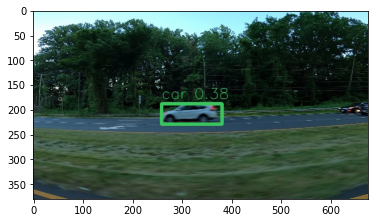

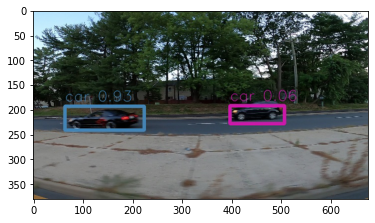

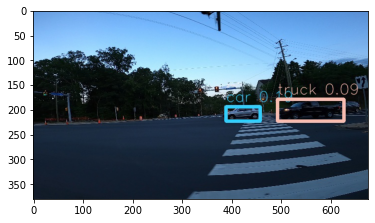

In [49]:
mostrar_resultados(c1)
mostrar_resultados(c2)
mostrar_resultados(c3)